In [79]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import os
import random

In [80]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [82]:
# Define the MLP model that takes the difference between two embeddings
class FaceVerificationMLP(nn.Module):
    def __init__(self, input_dim=512):
        super(FaceVerificationMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output: [same_person_prob, different_person_prob]
        )

    def forward(self, x):
        return self.model(x)

In [83]:
mtcnn = MTCNN(image_size=160, margin=20)

# Load FaceNet for embedding extraction (we'll be using a pretrained model)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

In [84]:
class FaceNotFoundException(Exception):
    pass

In [85]:
# Function to get face embedding from an image path
def get_embedding(image_path):
    img = Image.open(image_path).convert('RGB')
    face = mtcnn(img)  # returns a cropped, aligned face
    if face is None:
        raise FaceNotFoundException(f"No face detected in {image_path}")
    face_embedding = facenet(face.unsqueeze(0))  # Add batch dimension
    return face_embedding.detach()

# Function to compare two images and get the absolute difference vector
def get_diff_vector(img1_path, img2_path):
    emb1 = get_embedding(img1_path)
    emb2 = get_embedding(img2_path)
    return torch.abs(emb1 - emb2)

In [87]:
def train_model(train_data):
    # Prepare training tensors
    X_train = []
    y_train = []
    for img1, img2, label in train_data:
        try:
            diff = get_diff_vector(img1, img2)
        except FaceNotFoundException as err:
            print(err)
            continue
        X_train.append(diff.squeeze(0))
        y_train.append(label)

    X_train = torch.stack(X_train)
    y_train = torch.tensor(y_train)

    # Define model, loss, optimizer (note: this is an example, adjust it according to the task)
    model = FaceVerificationMLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the MLP model (note: this is an examople, adjust the number of epochs and additional stop criteria to the task in the Assignement 5 list)
    epochs = 20
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return model

In [88]:
# Prediction Example, for additional experiments you may want to return the decision in numeric form or add model certenity
def predict_same_person(img1_path, img2_path, model):
    model.eval()
    try:
        diff = get_diff_vector(img1_path, img2_path)
    except FaceNotFoundException as err:
        print(err)
        return 0
    output = model(diff)
    _, predicted = torch.max(output, 1)
    return 1 if predicted.item() == 1 else 0
    #return 'Same person' if predicted.item() == 1 else 'Different people'

# Example augmentation function
def augment_image(image, augment_type="gaussian_noise"):
    if augment_type == "gaussian_noise":
        # Add Gaussian noise
        image_np = np.array(image).astype(np.float32)
        # Modify the parameter value to adjust noise level if needed
        noise = np.random.normal(0, 25, image_np.shape)
        noisy_image = image_np + noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
        augmented = Image.fromarray(noisy_image)
    elif augment_type == "blur":
        # Apply Gaussian blur with radius 3
        augmented = image.filter(ImageFilter.GaussianBlur(radius=3))
    elif augment_type == "increased_lighting":
        # Increase brightness by 50%
        enhancer = ImageEnhance.Brightness(image)
        augmented = enhancer.enhance(1.5)
    else:
        augmented = image
    return augmented

# Zadanie 1.

In [89]:
def get_train_test_subset(n_train=1000, train_paired_ratio=0.5, n_test=200, test_paired_ratio=0.5):
    n_train_paired = int(n_train * train_paired_ratio)
    n_train_unpaired = n_train - n_train_paired
    n_test_paired = int(n_test * test_paired_ratio)
    n_test_unpaired = n_test - n_test_paired

    train_paired_data = []
    train_unpaired_data = []
    test_paired_data = []
    test_unpaired_data = []
    test_set = set()
    images_path = 'data/img_align_celeba'

    with open('data/Anno/identity_CelebA.txt', 'r') as file:
        identity_dict = defaultdict(list)
        file_identity_list = []
        for file_identity in file:
            try:
                file, identity = file_identity.split()
                file = os.path.join(images_path, file)
                identity = int(identity)
                identity_dict[identity].append(file)
                file_identity_list.append((file, identity))
            except ValueError as err:
                print(f"Error occurred in line {file_identity}: {err}")
        identities = list(identity_dict.keys())

        while len(train_paired_data) < n_train_paired:
            id = np.random.choice(identities)
            while len(identity_dict[id]) < 2:
                id = np.random.choice(identities)
            img_pair = np.random.choice(identity_dict[id], size=2, replace=False)
            train_paired_data.append((*img_pair, 1))
            test_set.add(id)

        while len(train_unpaired_data) < n_train_unpaired:
            ids = np.random.choice(identities, size=2, replace=False)
            img_pair = np.random.choice(identity_dict[ids[0]]), np.random.choice(identity_dict[ids[1]])
            train_unpaired_data.append((*img_pair, 0))
            test_set.add(ids[0])
            test_set.add(ids[1])

        test_identities = [id for id in identities if id not in test_set]
        while len(test_paired_data) < n_test_paired:
            id = np.random.choice(test_identities)
            while len(identity_dict[id]) < 2:
                id = np.random.choice(test_identities)
            img_pair = np.random.choice(identity_dict[id], size=2, replace=False)
            test_paired_data.append((*img_pair, 1))

        while len(test_unpaired_data) < n_test_unpaired:
            ids = np.random.choice(test_identities, size=2, replace=False)
            img_pair = np.random.choice(identity_dict[ids[0]]), np.random.choice(identity_dict[ids[1]])
            test_unpaired_data.append((*img_pair, 0))

        train_data = train_paired_data + train_unpaired_data
        test_data = test_paired_data + test_unpaired_data
        np.random.shuffle(train_data)
        np.random.shuffle(test_data)

        return train_data, test_data


In [90]:
n_test = 200
test_paired_ratio = 0.5
train_paired_ratio = 0.5

scores = {
    10: None,
    100: None,
    500: None,
    1000: None,
    5000: None
}

for n_train in scores:
    print(f"Training for {n_train} image pairs")

    train_data, test_data = get_train_test_subset(n_train, train_paired_ratio, n_test, test_paired_ratio)
    model = train_model(train_data)

    print(f"Training completed.\nPredicting...")

    predicted_data = []
    for d in test_data:
        predicted_data.append((d[0], d[1], predict_same_person(d[0], d[1], model)))

    print("Prediction completed.\n")

    Y_test = [x[2] for x in test_data]
    Y_predict = [y[2] for y in predicted_data]

    cm = confusion_matrix(Y_test, Y_predict)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict)
    precision = precision_score(Y_test, Y_predict)
    f1 = f1_score(Y_test, Y_predict)

    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
    scores[n_train] = metrics

    print(f"Results for {n_train} image pairs:")
    #print(f"Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}")
    for k, v in metrics.items():
        print(f"{k}: {v}")

Training for 10 image pairs
Epoch 1/20, Loss: 0.6946
Epoch 2/20, Loss: 0.6853
Epoch 3/20, Loss: 0.6779
Epoch 4/20, Loss: 0.6701
Epoch 5/20, Loss: 0.6620
Epoch 6/20, Loss: 0.6525
Epoch 7/20, Loss: 0.6418
Epoch 8/20, Loss: 0.6297
Epoch 9/20, Loss: 0.6165
Epoch 10/20, Loss: 0.6018
Epoch 11/20, Loss: 0.5859
Epoch 12/20, Loss: 0.5681
Epoch 13/20, Loss: 0.5490
Epoch 14/20, Loss: 0.5282
Epoch 15/20, Loss: 0.5059
Epoch 16/20, Loss: 0.4820
Epoch 17/20, Loss: 0.4568
Epoch 18/20, Loss: 0.4304
Epoch 19/20, Loss: 0.4032
Epoch 20/20, Loss: 0.3754
Training completed.
Predicting...
Prediction completed.

Results for 10 image pairs:
confusion_matrix: [[100   0]
 [ 72  28]]
accuracy: 0.64
recall: 0.28
precision: 1.0
f1: 0.4375
tp: 28
tn: 100
fp: 0
fn: 72
Training for 100 image pairs
Epoch 1/20, Loss: 0.6931
Epoch 2/20, Loss: 0.6870
Epoch 3/20, Loss: 0.6829
Epoch 4/20, Loss: 0.6779
Epoch 5/20, Loss: 0.6732
Epoch 6/20, Loss: 0.6686
Epoch 7/20, Loss: 0.6630
Epoch 8/20, Loss: 0.6571
Epoch 9/20, Loss: 0.6508

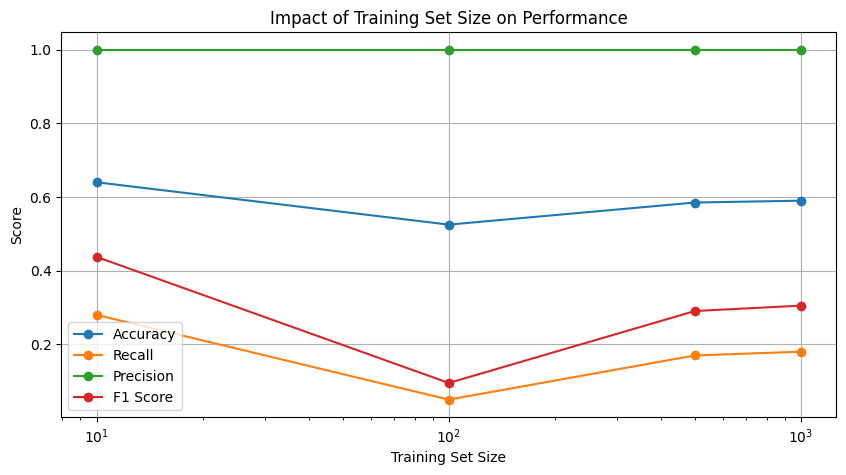

In [98]:
accuracies = [scores[s]['accuracy'] for s in scores]
recalls = [scores[s]['recall'] for s in scores]
precisions = [scores[s]['precision'] for s in scores]
f1_scores = [scores[s]['f1'] for s in scores]

plt.figure(figsize=(10, 5))
plt.plot(list(scores.keys()), accuracies, 'o-', label='Accuracy')
plt.plot(list(scores.keys()), recalls, 'o-', label='Recall')
plt.plot(list(scores.keys()), precisions, 'o-', label='Precision')
plt.plot(list(scores.keys()), f1_scores, 'o-', label='F1 Score')
plt.xscale('log')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Impact of Training Set Size on Performance')
plt.legend()
plt.grid(True)
plt.show()

# Zadanie 2.

In [ ]:
# TODO